# Quick Navigation
- [Skewness](#Skewness)
- 

# Skewness

The *third standardized moment* of a probability distribution, also known as *skewness*, can tell us whether a probability distribution is left- or right-skewed. 

What's nice about it is that it's an $O(n)$ calculation from the data, and confidence intervals can be constructed for it in $O(n)$ through the [delta method](https://en.wikipedia.org/wiki/Delta_method) (I don't implement confidence interval calculation here, sorry!). 

After all, if your dataset is small, you want to hold off on providing too many labels for your empirical distribution, since you're not highly confident in those labels. 

*In the context of Blastpoint*, this will happen if a user has selected *too small of a geographical area* - after using Blastpoint's application myself, I'm sure this happens all the time.

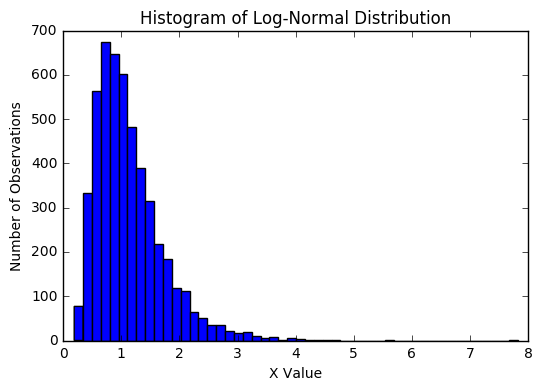

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data = np.exp(np.random.normal(0, 0.5, 5000))

n, bins, patches = plt.hist(data, 50)
plt.title("Histogram of Log-Normal Distribution")
plt.xlabel("X Value")
plt.ylabel("Number of Observations")

kurtosis estimate:  1.77812441966


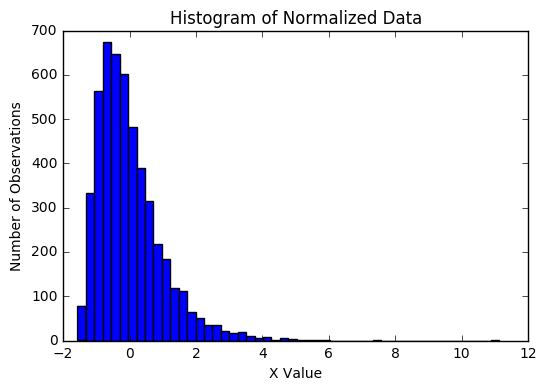

In [2]:
def getKurtHat(x):
    normedData = (x - np.mean(x))/np.std(x) #normalized data
    return np.mean(normedData**3) #estimate of third moment

n, bins, patches = plt.hist((data - np.mean(data))/np.std(data), 50) #histogram of normalized data
plt.title("Histogram of Normalized Data")
plt.xlabel("X Value")
plt.ylabel("Number of Observations")
print("kurtosis estimate: ", getKurtHat(data))

In [3]:
data *= -1 #now it's left-skewed
print("kurtosis estimate: ", getKurtHat(data))

kurtosis estimate:  -1.77812441966


### Things get ugly
Here's a case where I can't say whether it would be right to supply a user with a label of "left-skewed" or "right-skewed" at all. Maybe somebody else would say otherwise, but at any rate, it's very much a judgement call. 

Our kurtosis calculator, however, doesn't provide any sort of warning. 

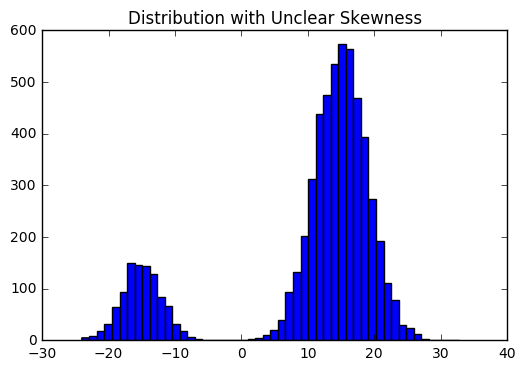

In [4]:
data = np.append(
    np.random.normal(-15, 3, 1000),
    np.random.normal(15, 4, 5000)
)

n, bins, patches = plt.hist(data, 50)
plt.title("Distribution with Unclear Skewness")

In [5]:
print("kurtosis estimate: ", getKurtHat(data))

kurtosis estimate:  -1.46507981461


I say that's insignificantly different than our previous two kurtosis calculations, and I don't think most humans would be very confident in their labels of left- or right-skewedness. 

I think the *fourth* moment can tell us whether the tails of the distribution are extreme enough to go with the kurtosis calculation's assessment.

### Tailedness
Okay, here's what we get for the weird bimodal distribution above.

In [6]:
def getTailHat(x):
    normedData = (x - np.mean(x))/np.std(x) #normalized data
    return np.mean(normedData**4) #estimate of fourth moment
print("kurtosis estimate:   ", getKurtHat(data), 
      "\ntailedness estimate: ", getTailHat(data))

kurtosis estimate:    -1.46507981461 
tailedness estimate:  3.79147862495


Here's the kurtosis and tailedness of a *lognormal distribution*, which is very clearly right-skewed.

In [7]:
data = np.exp(np.random.normal(0, 0.5, 5000))
print("kurtosis estimate:   ", getKurtHat(data), 
      "\ntailedness estimate: ", getTailHat(data))

kurtosis estimate:    1.97730827072 
tailedness estimate:  11.6632238832


Here's the kurtosis and tailedness of a lognormal distribution, which is symmetric. 

In [8]:
data = np.random.normal(0, 1, 5000)
print("kurtosis estimate:   ", getKurtHat(data), 
      "\ntailedness estimate: ", getTailHat(data))

kurtosis estimate:    0.0654861287181 
tailedness estimate:  3.01146182317


Basically, I'm saying that if the kurtosis is great in magnitude and the tailedness is significantly high, then it's probably skewed in a way that humans would agree with. Otherwise, don't supply a label.

**I'm not sure at all how robust this is** - I haven't thought about it too much, but there could easily be a case where the third and fourth moments would fail our purposes without warning. 

But if it *is* robust, then it's *for sure* preferable over the deep learning approach, not only because it's fast, but because we can be confident in our plain English descriptions.

# Density Estimation

Suppose you have data $X$ drawn from some underlying, unknown probability distribution, and you want to estimate that distribution. This is the fundamental goal of [density estimation](https://en.wikipedia.org/wiki/Density_estimation). When you want to provide a label of the *modality* of a distribution, you've basically wandered into the realm of density estimation.

The simplest and most familiar form of density estimation is the **humble histogram**.

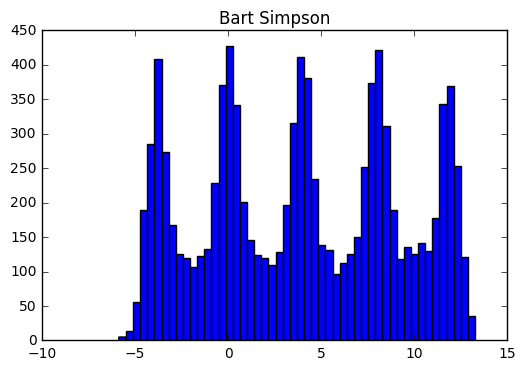

In [16]:
sigma = 0.5
data = np.append(
    np.random.normal(-4, sigma, 1000),
    np.random.normal(0, sigma, 1000))
data = np.append(data,
    np.random.normal(4, sigma, 1000))
data = np.append(data,
    np.random.normal(8, sigma, 1000))
data = np.append(data,
    np.random.normal(12, sigma, 1000))
data = np.append(data,
    np.random.uniform(-4, 12, 5000))

numBins = 50
n, bins, patches = plt.hist(data, numBins)
plt.title("Bart Simpson")

When we make a histogram, we divide our domain into a set of *bins* of equal length. The length, $h$, of each bar is the number of observations in each bin.

We can use it as a probability density estimator, too. Suppose you want a probability density estimate at point $x$. Choose the appropriate bin for $x$. Count the proportion of observations that fall in your bin and divide by bin size $h$.

From the histogram above, suppose you want a density estimate for $0$. It looks like $100$ observations were counted in the bin around $0$, and divide that by the total number of observations (9000) and the bin length (idk what that is here, sorry).

This brings us to a problem - for the histogram that provides the best density estimation, what's the optimal bin length?

The following are pretty bad choices of bin length (well, number of bins in this case):

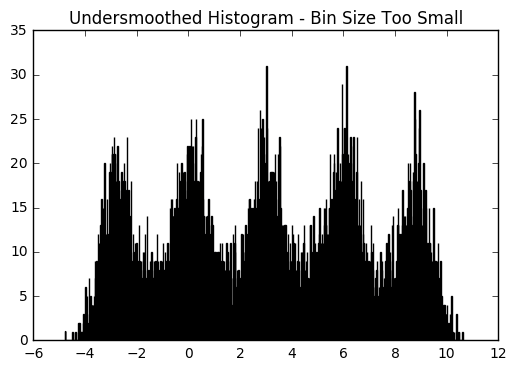

In [10]:
numBins = 1000
n, bins, patches = plt.hist(data, numBins)
plt.title("Undersmoothed Histogram - Bin Size Too Small")

Besides being un-analyzable, it also looks kind of spooky. Reminds me of the *Black Skinhead* video for some reason.

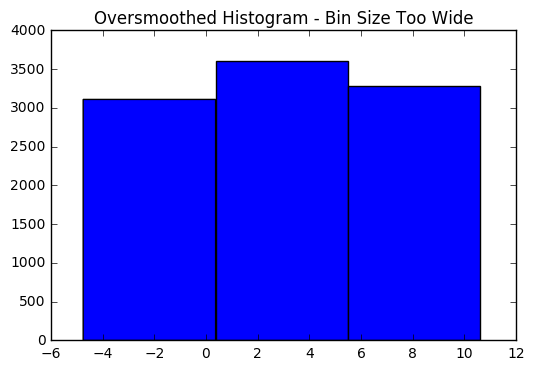

In [11]:
numBins = 3
n, bins, patches = plt.hist(data, numBins)
plt.title("Oversmoothed Histogram - Bin Size Too Wide")

Another problem histograms have is that they're jagged. Beyond aesthetic reasons, this could get in the way if we want something differentiable.  

Also, I can't help but think that the edges of the bins might be somehow... distracting (not sure how else to describe it). I'm sure it's possible to choose a set of convolutional filters such that this won't be a problem, but otherwise the CNN's confidence scores might be slightly lower than they rightly should be, thanks to the blocky edges of the histogram.

If we *smoothed* it somehow, we'd avoid the possibility of this problem. 

### Kernel Density Estimation

A kernel smoother is basically a grown-up histogram. It's a smoothed version of your data. It's very common to use a kernel smoother for regression, but it's also the go-to for density estimation.

Here's how we approximate the underlying distribution:

Just like in a histogram, we specify our *bandwidth parameter* ***h*** (analogous to bin size) first.

Our density estimate is below:

$$
\hat{f_h} = \frac{1}{nh} \sum_{i=1}^{n} K(\frac{x-x_i}{h})
$$

$K$ is a non-negative function that integrates to one and has mean zero. It's called a "kernel function", but confusingly, it has nothing to do with the kernel trick in machine learning. 

Common choices of kernel functions include the gaussian and uniform kernels, but the most common one is the gaussian one. That's what I'll use here, too.

One nice fact about kernel density estimation with a gaussian kernel is that it's differentiable. We can calculate first and second derivatives, which can help us count local maxima, and estimate whether they're representative of maxima in the underlying distribution. It might even help us describe skewness as well, although I've no idea how that would work yet.

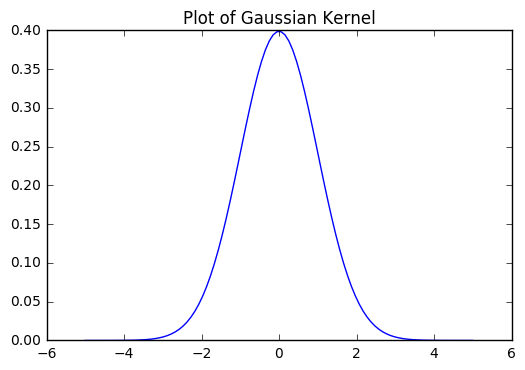

In [12]:
import scipy.stats as stats

def kern(z):
    return stats.norm.pdf(z)

x = np.linspace(-5, 5, 100)
plt.plot(x, kern(x))
plt.title("Plot of Gaussian Kernel")

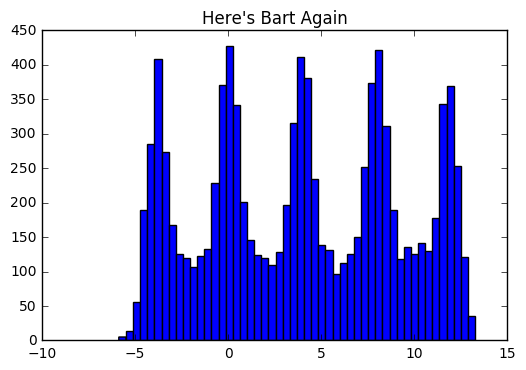

In [17]:
n, bins, patches = plt.hist(data, 50)
plt.title("Here's Bart Again")

In [18]:
def fHat(x, data, h):
    z = (x - data)/h
    weights = kern(z)
    return np.sum(weights) / (len(data)*h)

hOpt = np.std(data) * (3*len(data)/4)**(-1/5) #optimal h
print("optimal h: ", hOpt)

optimal h:  0.872986338228


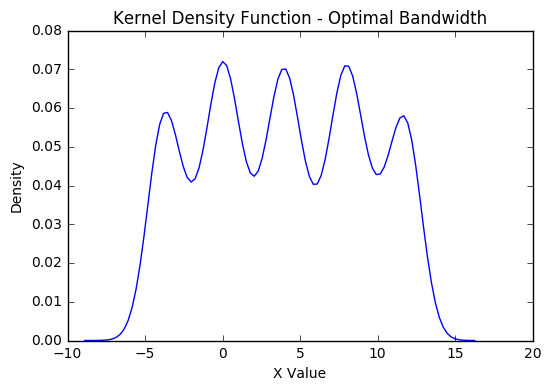

In [19]:
x = np.linspace(min(data) - 3, max(data) + 3, 100)
y = [fHat(elem, data, hOpt) for elem in x]
plt.plot(x, y)
plt.title("Kernel Density Function - Optimal Bandwidth")
plt.ylabel("Density")
plt.xlabel("X Value")

Wow, the essence of Bart is really strong here.

Still, this is kind of expensive! Because the Guassian kernel assigns a weight to every observation, you have to loop over the entire dataset, so a single calculation of the estimated density function is $O(n)$. 

Luckily, we can calculate the optimal bandwidth [in general](https://en.wikipedia.org/wiki/Kernel_density_estimation#A_rule-of-thumb_bandwidth_estimator), so we don't have to do cross-validation for $h$. If we do, we just do it in the neighborhood of that rule-of-thumb estimate, so it doesn't make much difference, really. 

Also, since the estimate of the optimal $h$ is a function of the sample standard deviation, we can construct confidence intervals for $h$ by constructing confidence intervals for the standard deviation, which is straightforward. This can help us assess our confidence in the CNN's predicted labels.

# Conclusion

I think there's still a lot to be gained by not discounting more traditional statistical methods for summarizing data in plain English. Before the success of machine learning, statisticians and physicists were faced with similar inference problems, and they left behind them a good deal of literature on the topic. 

Ultimately, deep learning will probably be the most appropriate, generalizable, and efficient solution, but I'm sure that analysis like this will heavily inform decisions in the development process. Skewness could very well be calculated by kurtosis, and preprocessing through kernel smoothing could lead to higher accuracy with a deep CNN.